### Selecionando os dados de comandantes

In [10]:
import requests as re
import wget
import json
import pandas as pd
# import streamlit as st

class ScryfallHandler:

    def __init__(self) -> None:
        self.__base_url = 'https://api.scryfall.com'
        self.__base_data_path = 'data'

    def download_bulk_data(self, database = 'All'):
        options = [
            'Oracle',
            'UniqueArtwork',
            'Default',
            'All',
            'Rulings'
        ]

        response = re.get(f'{self.__base_url}/bulk-data')
        if response.status_code == 200:
            data = response.json()
            wget.download(
                data['data'][options.index(database)]['download_uri'],
                f'{self.__base_data_path}/{database}.json'
            )
        else:
            print("Falha ao obter os dados", response.status_code)
            print("Resposta:", response.text)

    def commander_cards(self, option = 'data_frame'):
        '''
            options: data_frame | download
        '''
        query = (
            "is:legendary (type:creature OR (type:planeswalker "
            "AND oracle_text:'This card can be your commander'))"
        )
        response = re.get(f'{self.__base_url}/cards/search?q={query}')
        if response.status_code == 200:
            response = response.json()
            cards = response['data']
            total_cards = response['total_cards']
            # progress = 0
            # my_bar = st.progress(0, text="Buscando os dados. Por favor Aguarde")
            while response['has_more']:
                response = re.get(response['next_page']).json()
                cards.extend(response['data'])
            #     status = len(cards)
            #     progress = status / total_cards
            #     my_bar.progress(progress,
            #                     text=f"Buscando os dados. Por favor Aguarde. Status: {progress*100:.2f}%")
            # my_bar.empty()
            if option == 'data_frame':
                return pd.json_normalize(cards)

            if option == 'download':
                with open(f'{self.__base_data_path}/commader.json', 'w') as f:
                    json.dump(cards, f)
        else:
            print("Falha ao obter os dados", response.status_code)
            print("Resposta:", response.text)


In [11]:
scryfall_handler = ScryfallHandler()

def get_data():
    return scryfall_handler.commander_cards()


df_commander_cards = get_data()


In [13]:
df_commander_cards.columns

Index(['object', 'id', 'oracle_id', 'multiverse_ids', 'tcgplayer_id',
       'cardmarket_id', 'name', 'lang', 'released_at', 'uri',
       ...
       'preview.source_uri', 'preview.previewed_at', 'frame_effects',
       'mtgo_foil_id', 'penny_rank', 'watermark', 'produced_mana', 'loyalty',
       'tcgplayer_etched_id', 'color_indicator'],
      dtype='object', length=114)

In [14]:
import pandas as pd
import plotly.express as px

def split_types(type_line):
    if pd.isna(type_line):
        return []
    parts = type_line.split('—')
    if len(parts) > 1:
        subtypes = parts[1].split('//')
        return [subtype.strip() for subtype in subtypes]
    return []

def vis_type_line(df):

    df['main_type'] = df['type_line'].apply(lambda x: x.split('—')[0].strip())
    
    rank_type_line = df['main_type'].value_counts().sort_values(
        ascending=False)
    top_type_line = rank_type_line.head(10)

    df_filtered_type_line = df[df['main_type'].isin(top_type_line.index)]

    grouped_data = df_filtered_type_line.groupby('main_type')[
        'cmc'].agg(['mean', 'count']).reset_index()

    grouped_data.columns = ['main_type', 'cmc', 'TYPE_COUNT']
    mean_cmc = grouped_data.sort_values(by='cmc', ascending=False)

    mean_cmc['cmc'] = round(mean_cmc['cmc'], 2)

    fig1 = px.bar(top_type_line, x=top_type_line.index, y=top_type_line.values,
                  color=top_type_line.index, text=top_type_line.values,
                  labels={'main_type': 'Tipos de Criaturas dos Comandantes',
                          'y': 'Total'},
             template='seaborn',
             title='<b> Criaturas mais frequentes')
    fig1.update_layout(showlegend=False)
    fig1.update_yaxes(tickformat="000")

    fig2 = px.bar(mean_cmc, x='main_type', y='cmc',
                color='main_type',
                labels={'main_type': 'Tipos de Criaturas dos Comandantes',
                        'cmc': 'CMC MÉDIO'},
                text='TYPE_COUNT',
                template='seaborn',
                title='<b> CMC Médio por Tipo de Criatura')
    fig2.update_layout(showlegend=False)
    fig2.update_yaxes(tickformat="000")
    fig2.update_traces(textfont_size=8)

    return fig1, fig2

In [ ]:
def split_types(type_line):
    if pd.isna(type_line):
        return []
    parts = type_line.split('—')
    if len(parts) > 1:
        subtypes = parts[1].split('//')
        return [subtype.strip() for subtype in subtypes]
    return []

# Aplicar a função de separação e explodir a coluna resultante
df['subtypes'] = df['type_line'].apply(split_types)

In [24]:
import pandas as pd
import plotly.express as px

def split_types(type_line):
    if pd.isna(type_line):
        return []
    parts = type_line.split('—')
    if len(parts) > 1:
        subtypes = parts[1].split('//')
        return [subtype.strip() for subtype in subtypes]
    return []

def vis_type_line(df):
    # Aplica a função split_types para processar os subtipos
    df['subtypes'] = df['type_line'].apply(split_types)
    
    # Explode os subtipos em linhas separadas para cada subtipo
    df_exploded = df.explode('subtypes')

    # Calcula a contagem dos subtipos
    rank_subtype = df_exploded['subtypes'].value_counts().sort_values(ascending=False)
    top_subtype = rank_subtype.head(10)

    # Filtra apenas os subtipos mais frequentes para análise
    df_filtered_subtype = df_exploded[df_exploded['subtypes'].isin(top_subtype.index)]

    # Agrupa por subtipo e calcula a média e a contagem do CMC
    grouped_data = df_filtered_subtype.groupby('subtypes')['cmc'].agg(['mean', 'count']).reset_index()
    grouped_data.columns = ['subtypes', 'cmc', 'TYPE_COUNT']
    mean_cmc = grouped_data.sort_values(by='cmc', ascending=False)
    mean_cmc['cmc'] = round(mean_cmc['cmc'], 2)

    # Cria os gráficos
    fig1 = px.bar(top_subtype, x=top_subtype.index, y=top_subtype.values,
                  color=top_subtype.index, text=top_subtype.values,
                  labels={'subtypes': 'Subtipos Mais Frequentes', 'y': 'Total'},
                  template='seaborn', title='<b>Subtipos Mais Frequentes')
    fig1.update_layout(showlegend=False)
    fig1.update_yaxes(tickformat="000")

    fig2 = px.bar(mean_cmc, x='subtypes', y='cmc',
                  color='subtypes',
                  labels={'subtypes': 'Subtipos de Criaturas', 'cmc': 'CMC Médio'},
                  text='TYPE_COUNT',
                  template='seaborn', title='<b>CMC Médio por Subtipo de Criatura')
    fig2.update_layout(showlegend=False)
    fig2.update_yaxes(tickformat="000")
    fig2.update_traces(textfont_size=8)

    return fig1, fig2

# Supondo que você já tem um DataFrame df carregado com as colunas 'type_line' e 'cmc'
# Exemplo de chamada:
# fig1, fig2 = vis_type_line(df)
# fig1.show()
# fig2.show()


In [25]:
fig_count, fig_avg_cmc = vis_type_line(df_commander_cards)


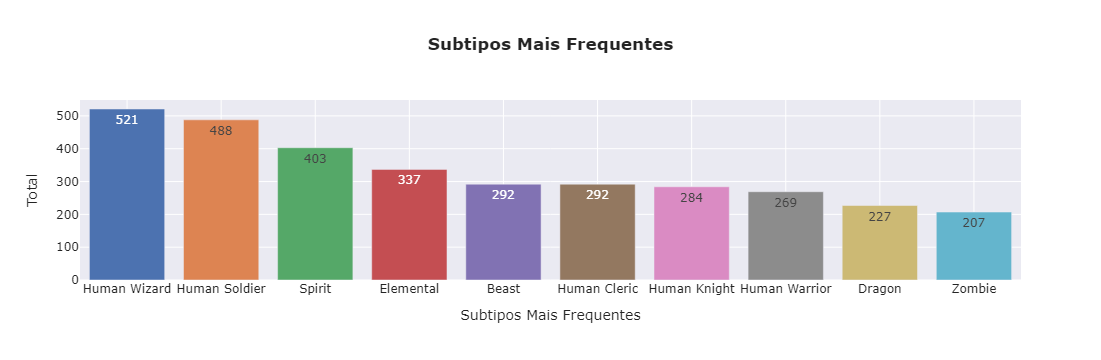

In [26]:
fig_count

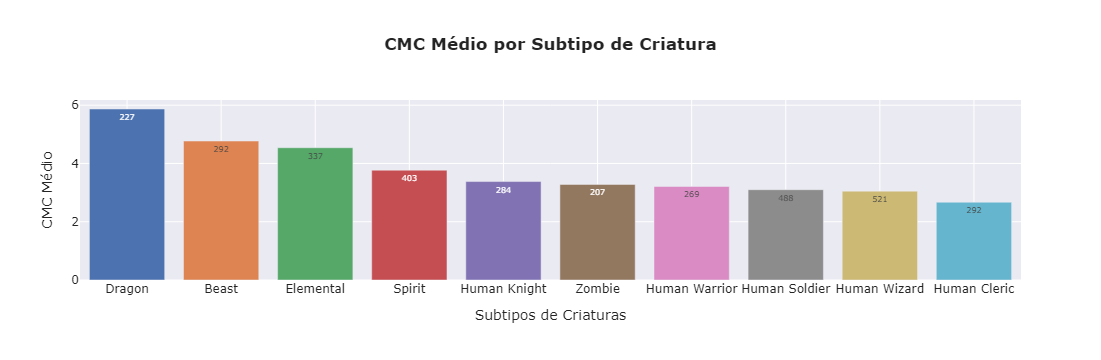

In [23]:
fig_avg_cmc

In [5]:
df['keywords']

0               [Venture into the dungeon]
1                           [Scry, Flying]
2       [Mark of Chaos Ascendant, Trample]
3       [Mark of Chaos Ascendant, Trample]
4       [Mark of Chaos Ascendant, Trample]
                       ...                
8780                              [Flying]
8781                              [Flying]
8782                              [Flying]
8783                                    []
8784                                    []
Name: keywords, Length: 8785, dtype: object

In [6]:
df.columns

Index(['object', 'id', 'oracle_id', 'multiverse_ids', 'arena_id', 'name',
       'lang', 'released_at', 'uri', 'scryfall_uri', 'layout', 'highres_image',
       'image_status', 'image_uris', 'mana_cost', 'cmc', 'type_line',
       'oracle_text', 'power', 'toughness', 'colors', 'color_identity',
       'keywords', 'all_parts', 'legalities', 'games', 'reserved', 'foil',
       'nonfoil', 'finishes', 'oversized', 'promo', 'reprint', 'variation',
       'set_id', 'set', 'set_name', 'set_type', 'set_uri', 'set_search_uri',
       'scryfall_set_uri', 'rulings_uri', 'prints_search_uri',
       'collector_number', 'digital', 'rarity', 'card_back_id', 'artist',
       'artist_ids', 'illustration_id', 'border_color', 'frame',
       'security_stamp', 'full_art', 'textless', 'booster', 'story_spotlight',
       'promo_types', 'prices', 'related_uris', 'card_faces', 'mtgo_id',
       'tcgplayer_id', 'cardmarket_id', 'flavor_text', 'frame_effects',
       'edhrec_rank', 'purchase_uris', 'preview', 

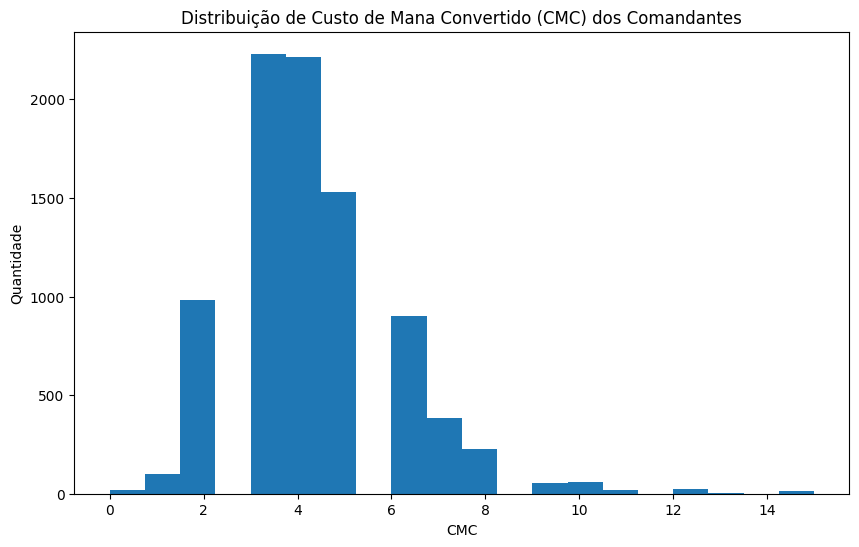

In [7]:
# Histograma para Distribuição de CMC
df['cmc'].plot(kind='hist', bins=20, figsize=(10, 6))
plt.title('Distribuição de Custo de Mana Convertido (CMC) dos Comandantes')
plt.xlabel('CMC')
plt.ylabel('Quantidade')
plt.show()



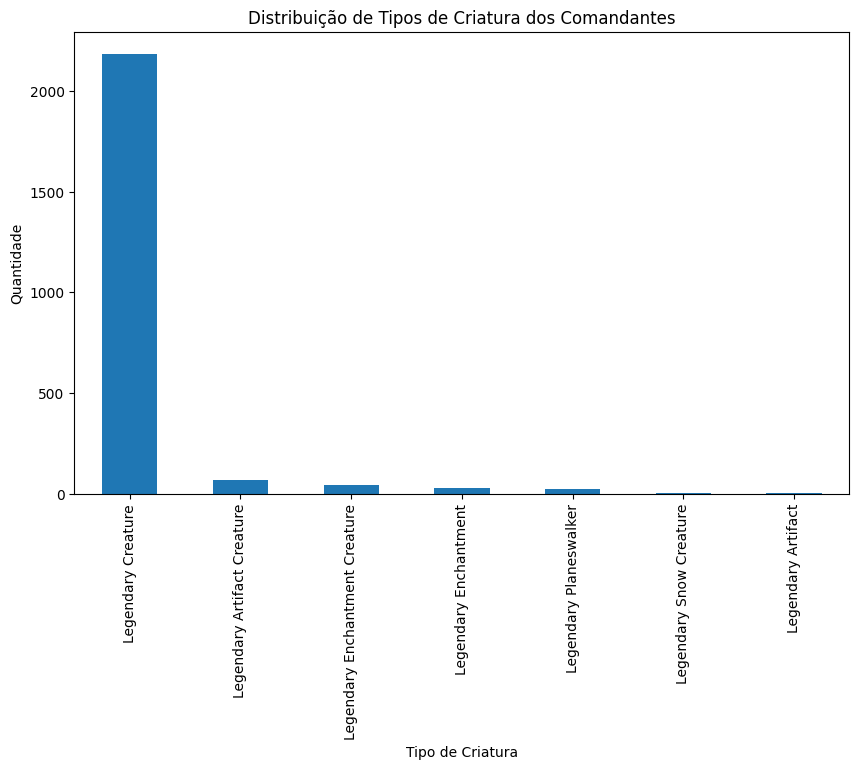

In [6]:
# # Gráfico de Barras para Tipos de Criatura
# df['main_type'] = df['type_line'].apply(lambda x: x.split('—')[0].strip())
# type_counts = df['main_type'].value_counts()
# type_counts.plot(kind='bar', figsize=(10, 6))
# plt.title('Distribuição de Tipos de Criatura dos Comandantes')
# plt.xlabel('Tipo de Criatura')
# plt.ylabel('Quantidade')
# plt.show()



In [8]:
df['type_line']

0                      Legendary Creature — Zombie Wizard
1       Legendary Creature — God // Legendary Creature...
2                   Legendary Creature — Astartes Warrior
3                   Legendary Creature — Astartes Warrior
4                   Legendary Creature — Astartes Warrior
                              ...                        
8780                    Legendary Creature — Human Wizard
8781                    Legendary Creature — Human Wizard
8782                    Legendary Creature — Human Wizard
8783                           Legendary Creature — Devil
8784                           Legendary Creature — Devil
Name: type_line, Length: 8785, dtype: object

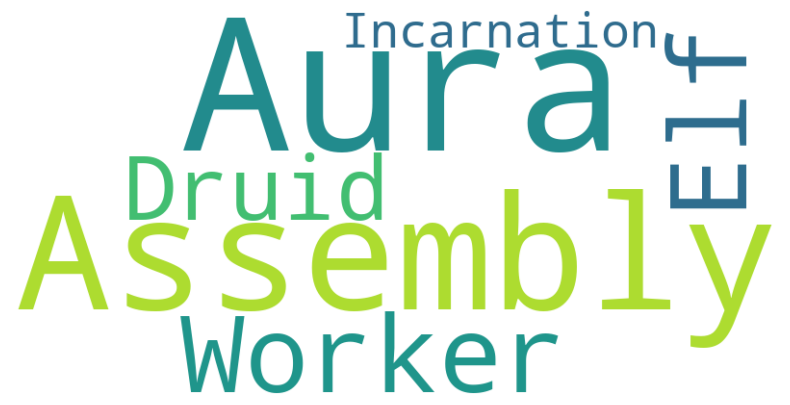

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Função para separar os tipos de criaturas
def split_types(type_line):
    parts = type_line.split('—')
    if len(parts) > 1:
        subtypes = parts[1].split('//')
        return [subtype.strip() for subtype in subtypes]
    return []

# Aplicar a função de separação e explodir a coluna resultante
df['subtypes'] = df['type_line'].apply(split_types)
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Supondo que df é seu DataFrame original
# Explodir a coluna 'subtypes'
df_exploded = df.explode('subtypes')

# Substituir NaNs por strings vazias
df_exploded['subtypes'] = df_exploded['subtypes'].fillna('')

# Converter todos os valores em 'subtypes' para strings
df_exploded['subtypes'] = df_exploded['subtypes'].astype(str)

# Gerar a string para a nuvem de palavras
all_subtypes = ' '.join(df_exploded['subtypes'])

# Gerar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_subtypes)

# Plotar a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



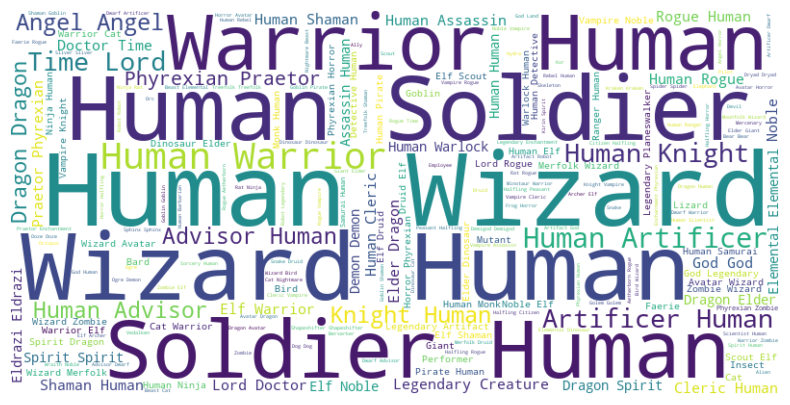

In [10]:
# Função para separar os tipos de criaturas
def split_types(type_line):
    if pd.isna(type_line):
        return []
    parts = type_line.split('—')
    if len(parts) > 1:
        subtypes = parts[1].split('//')
        return [subtype.strip() for subtype in subtypes]
    return []

# Aplicar a função de separação e explodir a coluna resultante
df['subtypes'] = df['type_line'].apply(split_types)

# Explodir a coluna 'subtypes'
df_exploded = df.explode('subtypes')

# Substituir NaNs por strings vazias
df_exploded['subtypes'] = df_exploded['subtypes'].fillna('')

# Converter todos os valores em 'subtypes' para strings
df_exploded['subtypes'] = df_exploded['subtypes'].astype(str)

# Gerar a string para a nuvem de palavras
all_subtypes = ' '.join(df_exploded['subtypes'])

# Gerar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_subtypes)

# Plotar a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [10]:
df_exploded

,object,id,oracle_id,multiverse_ids,arena_id,name,lang,released_at,uri,scryfall_uri,...,preview,mtgo_foil_id,penny_rank,produced_mana,watermark,loyalty,color_indicator,tcgplayer_etched_id,main_type,subtypes
0,card,eb363654-2004-4db8-bbd2-5b121da4f2a0,f0cc4b7d-3b52-4a16-8ae7-4e64a682e43d,[],77192.0,A-Acererak the Archlich,en,2021-07-23,https://api.scryfall.com/cards/eb363654-2004-4...,https://scryfall.com/card/afr/A-87/a-acererak-...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Legendary Creature,Zombie Wizard
1,card,b443504e-1b25-4565-bad7-2575826c7bb9,2d6186a6-5236-4fb9-bcb6-f6825b148886,[],75077.0,"A-Alrund, God of the Cosmos // A-Hakka, Whispe...",en,2021-02-05,https://api.scryfall.com/cards/b443504e-1b25-4...,https://scryfall.com/card/khm/A-40/a-alrund-go...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Legendary Creature,God
1,card,b443504e-1b25-4565-bad7-2575826c7bb9,2d6186a6-5236-4fb9-bcb6-f6825b148886,[],75077.0,"A-Alrund, God of the Cosmos // A-Hakka, Whispe...",en,2021-02-05,https://api.scryfall.com/cards/b443504e-1b25-4...,https://scryfall.com/card/khm/A-40/a-alrund-go...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Legendary Creature,Legendary Creature
2,card,c9f1fc97-00c0-492b-a4a3-b179afc2f95d,8dedb9a7-0afa-4dff-b124-2344c170f11a,[],NaN,Abaddon the Despoiler,en,2022-10-07,https://api.scryfall.com/cards/c9f1fc97-00c0-4...,https://scryfall.com/card/40k/2/abaddon-the-de...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Legendary Creature,Astartes Warrior
3,card,396f9198-67b6-45d8-91b4-dc853bff9623,cab092f9-b7ff-43b9-935f-310869a4daf8,[562885],NaN,"Abdel Adrian, Gorion's Ward",en,2022-06-10,https://api.scryfall.com/cards/396f9198-67b6-4...,https://scryfall.com/card/clb/2/abdel-adrian-g...,...,"{'source': 'Wizards of the Coast', 'source_uri...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Legendary Creature,Human Warrior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,card,eacbcd82-36e6-424c-bd4e-ec3a584836c5,941c9acd-2773-456a-88d5-0537735f93c6,[607329],84565.0,Zurgo and Ojutai,en,2023-04-21,https://api.scryfall.com/cards/eacbcd82-36e6-4...,https://scryfall.com/card/mom/258/zurgo-and-oj...,...,NaN,NaN,5445.0,NaN,NaN,NaN,NaN,NaN,Legendary Creature,Orc Dragon
2350,card,bbac6d75-59ab-4d7d-87ae-46875abf8cc7,46808926-d95b-4313-89d1-6bdfe13fcb77,[394748],NaN,Zurgo Bellstriker,en,2015-03-27,https://api.scryfall.com/cards/bbac6d75-59ab-4...,https://scryfall.com/card/dtk/169/zurgo-bellst...,...,NaN,56051.0,459.0,NaN,kolaghan,NaN,NaN,NaN,Legendary Creature,Orc Warrior
2351,card,13f4bafe-0d21-47ba-8f16-0274107d618c,6c48d888-9f5d-43f4-adbd-61dbdba09260,[386731],58365.0,Zurgo Helmsmasher,en,2014-09-26,https://api.scryfall.com/cards/13f4bafe-0d21-4...,https://scryfall.com/card/ktk/214/zurgo-helmsm...,...,NaN,54251.0,10329.0,NaN,mardu,NaN,NaN,NaN,Legendary Creature,Orc Warrior
2352,card,561cfc04-65ea-49a4-8638-b4631a7cf828,d7950018-d744-48a8-81aa-0d8384703f48,[599080],NaN,Zur the Enchanter,en,2023-01-13,https://api.scryfall.com/cards/561cfc04-65ea-4...,https://scryfall.com/card/dmr/206/zur-the-ench...,...,NaN,NaN,4988.0,NaN,NaN,NaN,NaN,NaN,Legendary Creature,Human Wizard


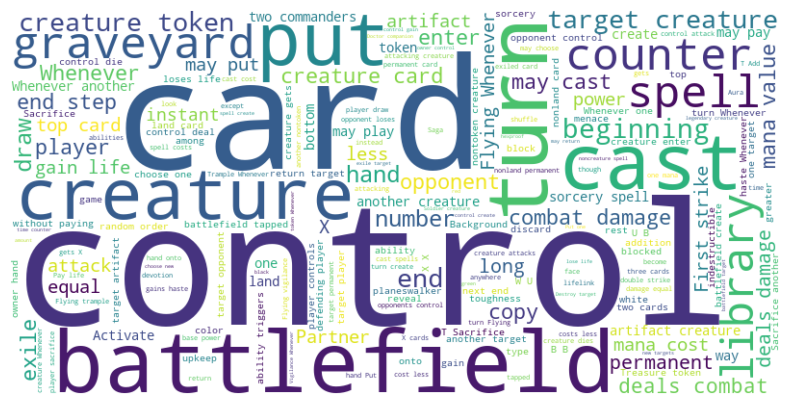

In [11]:
import seaborn as sns
from wordcloud import WordCloud
# Nuvem de Palavras para texto carta
all_text = ' '.join(df['oracle_text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

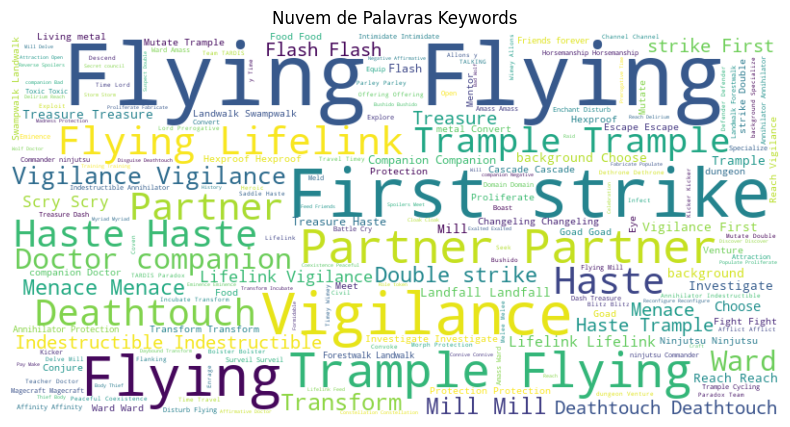

In [12]:


# Combinar todas as palavras-chave em uma única string para a nuvem de palavras combinada
all_keywords_combined = ' '.join([' '.join(keywords) for keywords in df['keywords']])

# Criar uma string com cada palavra-chave individualmente para a nuvem de palavras de módulos individuais
individual_keywords = ' '.join([keyword for keywords in df['keywords'] for keyword in keywords])

# Gerar a nuvem de palavras combinada
wordcloud_combined = WordCloud(width=800, height=400, background_color='white').generate(all_keywords_combined)

# # Gerar a nuvem de palavras individual
# wordcloud_individual = WordCloud(width=800, height=400, background_color='white').generate(individual_keywords)

# Plotar a nuvem de palavras combinada
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_combined, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras Keywords')
plt.show()

# # Plotar a nuvem de palavras individual
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud_individual, interpolation='bilinear')
# plt.axis('off')
# plt.title('Nuvem de Palavras Individual')
# plt.show()


In [15]:
from pyedhrec import EDHRec


edhrec = EDHRec()

# Reference cards by the exact card name, the library will format as needed
miirym = "Miirym, Sentinel Wyrm"

# Get basic card details
details = edhrec.get_card_details(miirym)

# Get details for a list of cards
card_list = edhrec.get_card_list(["Pongify", "Farseek"])

# Get an edhrec.com link for a given card
miirym_link = edhrec.get_card_link(miirym)

# Get combos for a card
miirym_combos = edhrec.get_card_combos(miirym)

# Get commander data 
miirym_commander_data = edhrec.get_commander_data(miirym)

# Get cards commonly associated with a commander
miirym_cards = edhrec.get_commander_cards(miirym)

# Get the average decklist for a commander
miirym_avg_deck = edhrec.get_commanders_average_deck(miirym)

# Get known deck lists for a commander
miirym_decks = edhrec.get_commander_decks(miirym)

# This library provides several methods to get specific types of recommended cards
new_cards = edhrec.get_new_cards(miirym)
high_synergy_cards = edhrec.get_high_synergy_cards(miirym)

# Get all top cards
top_cards = edhrec.get_top_cards(miirym)

# Get specific top cards by type
top_creatures = edhrec.get_top_creatures(miirym)
top_instants = edhrec.get_top_instants(miirym)
top_sorceries = edhrec.get_top_sorceries(miirym)
top_enchantments = edhrec.get_top_enchantments(miirym)
top_artifacts = edhrec.get_top_artifacts(miirym)
top_mana_artifacts = edhrec.get_top_mana_artifacts(miirym)
top_battles = edhrec.get_top_battles(miirym)
top_planeswalkers = edhrec.get_top_planeswalkers(miirym)
top_utility_lands = edhrec.get_top_utility_lands(miirym)
top_lands = edhrec.get_top_lands(miirym)

In [ ]:
top_creatures

Error fetching data: 404
Empty DataFrame
Columns: []
Index: []


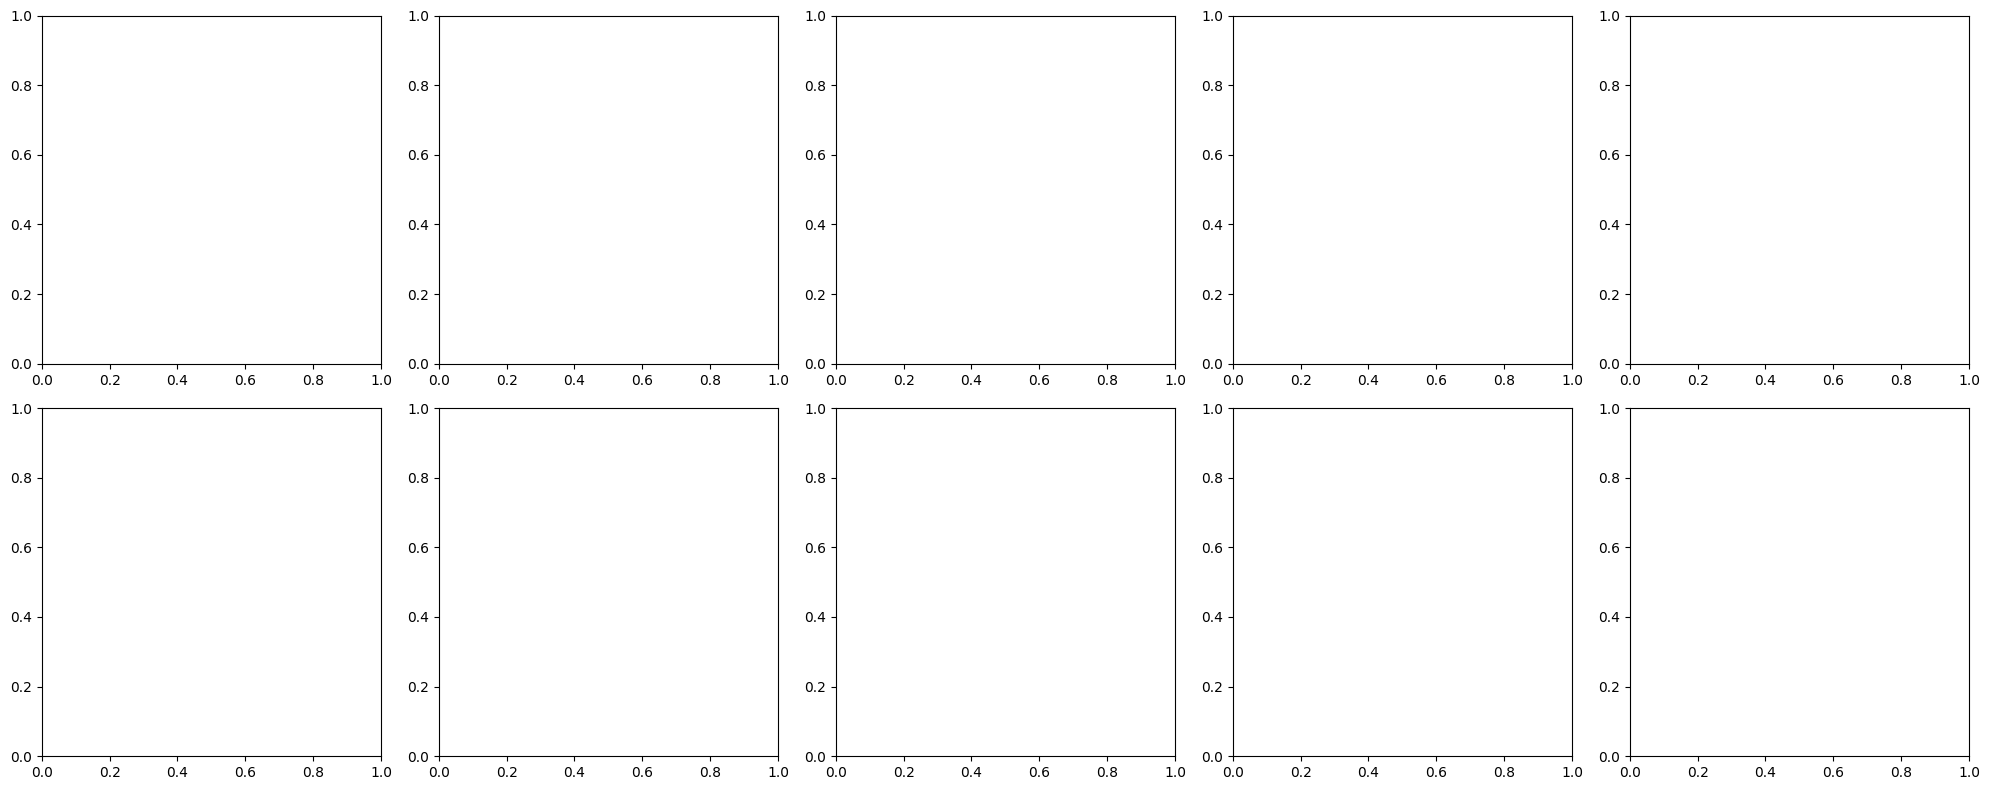

KeyError: "None of [Index(['name', 'edhrec_rank', 'image_uris'], dtype='object')] are in the [columns]"

In [14]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

def get_top_edhrec_cards():
    # Endpoint to search for top EDHREC cards
    search_url = "https://api.scryfall.com/cards/search"
    query = {
        "q": "edhrec_rank<=10",
        "order": "edhrec",
        "dir": "asc",
        "unique": "cards",
        "include_extras": "false",
        "include_variations": "false",
        "page": 1
    }

    response = requests.get(search_url, params=query)
    if response.status_code == 200:
        return response.json()['data']
    else:
        print(f"Error fetching data: {response.status_code}")
        return []

# Fetch the top 10 cards
top_cards = get_top_edhrec_cards()

# Extract relevant data and create a DataFrame
cards_data = [{
    "name": card["name"],
    "edhrec_rank": card.get("edhrec_rank", "N/A"),
    "image_uris": card.get("image_uris", {}),
    "set_name": card["set_name"],
    "released_at": card["released_at"]
} for card in top_cards]

df_top_cards = pd.DataFrame(cards_data)

# Mostrar DataFrame das top 10 cartas para verificar colunas
print(df_top_cards.head())

# Mostrar imagens das cartas
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, (index, row) in enumerate(df_top_cards.iterrows()):
    image_uris = row['image_uris']
    if isinstance(image_uris, dict):
        img_url = image_uris.get('normal')
        if img_url:
            response = requests.get(img_url)
            img = Image.open(BytesIO(response.content))
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"{row['name']} (Rank: {row['edhrec_rank']})", fontsize=12)
        else:
            axes[i].axis('off')
            axes[i].set_title(f"{row['name']} (Rank: {row['edhrec_rank']})\nImagem não disponível", fontsize=12)
    else:
        axes[i].axis('off')
        axes[i].set_title(f"{row['name']} (Rank: {row['edhrec_rank']})\nImagem não disponível", fontsize=12)

plt.tight_layout()
plt.show()

# Mostrar DataFrame dos top 10 comandantes
print(df_top_cards[['name', 'edhrec_rank', 'image_uris']])


In [15]:
import requests
import pandas as pd

def get_top_edhrec_cards():
    # Endpoint to search for top EDHREC cards
    search_url = "https://api.scryfall.com/cards/search"
    query = {
        "q": "edhrec_rank<=10",
        "order": "edhrec",
        "dir": "asc",
        "unique": "cards",
        "include_extras": "false",
        "include_variations": "false",
        "page": 1
    }

    response = requests.get(search_url, params=query)
    if response.status_code == 200:
        return response.json()['data']
    else:
        print(f"Error fetching data: {response.status_code}")
        return []

# Fetch the top 10 cards
top_cards = get_top_edhrec_cards()

# Extract relevant data and create a DataFrame
cards_data = [{
    "name": card["name"],
    "edhrec_rank": card.get("edhrec_rank", "N/A"),
    "set_name": card["set_name"],
    "released_at": card["released_at"]
} for card in top_cards]

df_top_cards = pd.DataFrame(cards_data)

# Display the DataFrame
print(df_top_cards)


Error fetching data: 404
Empty DataFrame
Columns: []
Index: []


In [ ]:
### CArtas Legais no commander

In [38]:
df_commander_legal_cards

,object,id,oracle_id,multiverse_ids,mtgo_id,arena_id,tcgplayer_id,cardmarket_id,name,lang,...,promo_types,mtgo_foil_id,produced_mana,penny_rank,card_faces,watermark,loyalty,color_indicator,tcgplayer_etched_id,attraction_lights
0,card,e882c9f9-bf30-46b6-bedc-379d2c80e5cb,629fe1be-272d-465f-b9b1-2ce177410f13,[],91504.0,77106.0,243201.0,571299.0,+2 Mace,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,card,2a83882c-3e03-4e85-aaac-97fa1d08a772,c1882cb4-f69e-441e-8871-743ed636cad0,[562937],100106.0,NaN,272557.0,658454.0,Aarakocra Sneak,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,card,c9f1fc97-00c0-492b-a4a3-b179afc2f95d,8dedb9a7-0afa-4dff-b124-2344c170f11a,[],108844.0,NaN,285789.0,674640.0,Abaddon the Despoiler,en,...,[surgefoil],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,card,4945031e-1158-474c-9e50-1ec817acc767,5a70ccfa-d12d-4e62-a1a4-f05cda2fd442,[31761],16467.0,NaN,9587.0,2724.0,Abandoned Outpost,en,...,NaN,16468.0,"[B, G, R, U, W]",7974.0,NaN,NaN,NaN,NaN,NaN,NaN
4,card,23b587f3-5eac-45a7-a048-dd73d2a2b74f,a051dee0-60c8-4f58-84cb-55460c097115,[482864],NaN,NaN,212339.0,454298.0,Abandoned Sarcophagus,en,...,NaN,NaN,NaN,4296.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2620,card,83327f18-f9f6-4f9b-b72a-68f85ad96b00,a0f6834c-faa9-4d90-adad-847a8b337fe6,[625279],114089.0,NaN,505168.0,722893.0,Bonesplitter Sliver,en,...,NaN,NaN,NaN,9582.0,NaN,NaN,NaN,NaN,NaN,NaN
2621,card,297d7326-ad03-464d-97e2-443042d48f92,32bb6d53-3b9e-4f13-a17e-46b564afd366,[44342],18762.0,NaN,10907.0,1075.0,Bonethorn Valesk,en,...,NaN,18763.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2622,card,df5dd873-af44-45eb-9b82-a3622cc58b35,31be5bf4-9950-456c-8365-74b48e132ef5,[466802],72995.0,69833.0,192866.0,379422.0,Bone to Ash,en,...,NaN,NaN,NaN,9185.0,NaN,NaN,NaN,NaN,NaN,NaN
2623,card,d43981b1-60c8-4896-8885-b07e73b99b30,c3adc698-a0c5-4c82-8347-536745c9e928,[655022],124073.0,90427.0,544471.0,764090.0,Boneyard Desecrator,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df=df_commander_legal_cards
df = df.sort_values('edhrec_rank')

In [41]:
df['edhrec_rank'].head(10)

924      3.0
1920    21.0
2192    26.0
2556    31.0
2096    39.0
1083    53.0
666     55.0
2442    62.0
911     70.0
790     77.0
Name: edhrec_rank, dtype: float64

In [32]:
df['edhrec_rank']

33       171
80       309
147      402
151      528
84       553
       ...  
145    26184
105    26190
144    26217
11     26515
39     26533
Name: edhrec_rank, Length: 175, dtype: int64

KeyError: 'image_uris'

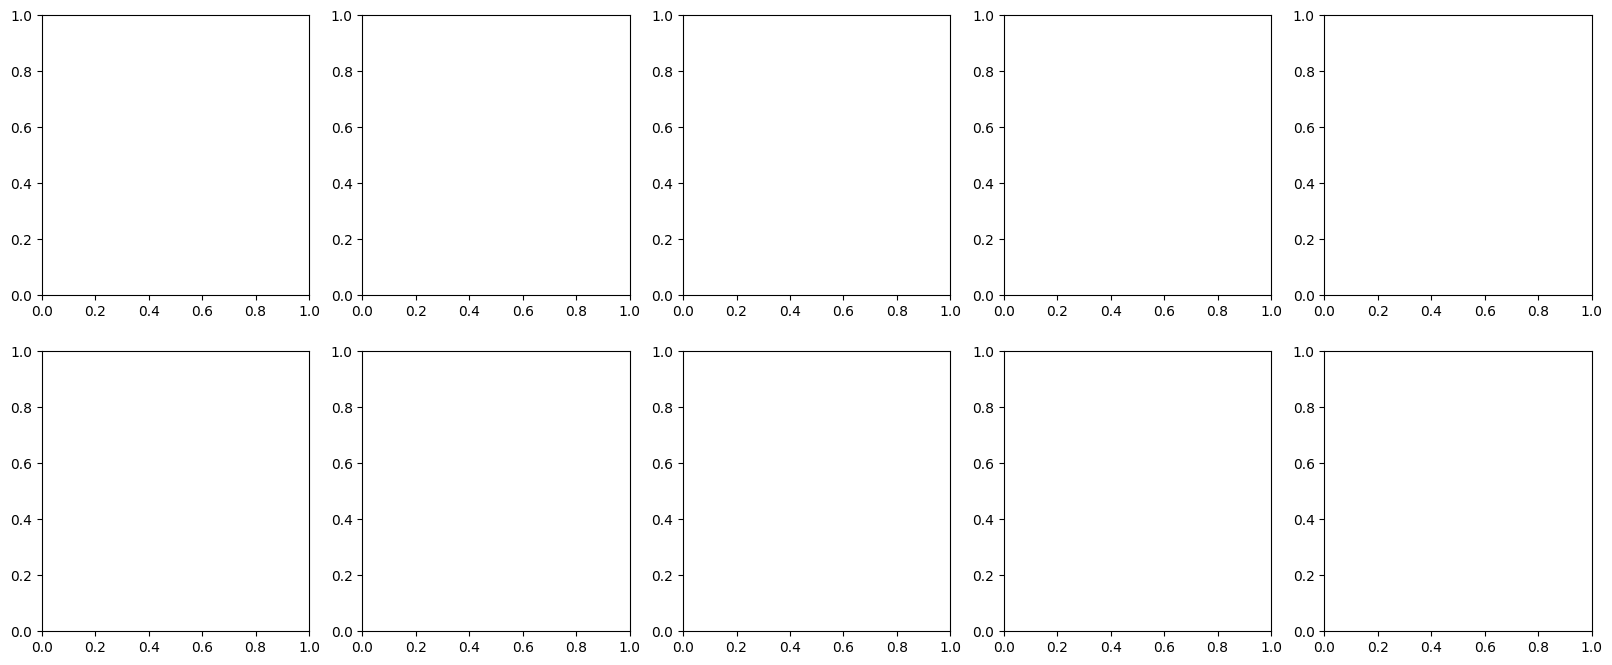

In [37]:

df = df[df['edhrec_rank'].notnull()]  # Filtrar cartas sem rank EDHREC
df = df.sort_values('edhrec_rank').head(10)  # Top 10 cartas

# Mostrar imagens das cartas
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, (index, row) in enumerate(df.iterrows()):
    image_uris = row['image_uris']
    if isinstance(image_uris, dict):
        img_url = image_uris.get('normal')
        if img_url:
            response = requests.get(img_url)
            img = Image.open(BytesIO(response.content))
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"{row['name']} (Rank: {row['edhrec_rank']})", fontsize=12)
        else:
            axes[i].axis('off')
            axes[i].set_title(f"{row['name']} (Rank: {row['edhrec_rank']})\nImagem não disponível", fontsize=12)
    else:
        axes[i].axis('off')
        axes[i].set_title(f"{row['name']} (Rank: {row['edhrec_rank']})\nImagem não disponível", fontsize=12)

plt.tight_layout()
plt.show()

# Mostrar DataFrame dos top 10 comandantes
# df_top_10 = df[['name', 'edhrec_rank', 'image_uris']]
# print(df_top_10)

In [21]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO


# Função para buscar cartas aptas a serem comandantes
def fetch_all_data():
    url = "https://api.scryfall.com/cards/search"
    params = {
        'order': 'name',  # Ordenar os resultados pelo nome
        'unique': 'prints'  # Filtrar por impressões únicas
    }
    cards = []
    while url:
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            cards.extend(data['data'])
            url = data['next_page'] if 'next_page' in data else None
        else:
            print(f"Erro na busca: {response.status_code}")
            break
    return cards


cards = fetch_all_data()

# Convertendo para DataFrame
df = pd.DataFrame(cards)

Erro na busca: 400


In [55]:
def fetch_legal_commander_cards():
    url = "https://api.scryfall.com/cards/search"
    query = "legal:commander"
    response = requests.get(f"{url}?q={query}")
    data = response.json()
    return pd.DataFrame(data['data'])

# Exemplo: Buscar cartas legais em Commander
df_commander = fetch_legal_commander_cards()



In [44]:
import requests
import pandas as pd

def fetch_cards_by_edhrec_rank(edhrec_rank):
    url = f"https://api.scryfall.com/cards/search?q=in:commander "
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if 'data' in data:
            return pd.json_normalize(data['data'])
        else:
            print("Nenhuma carta encontrada com o edhrec_rank especificado.")
    else:
        print("Falha ao obter os dados", response.status_code)
        print("Resposta:", response.text)
    return pd.DataFrame()  # Retorna um DataFrame vazio se não houver sucesso

# Uso da função
# edhrec_rank = 1
df_cards = fetch_cards_by_edhrec_rank(edhrec_rank)
# print(df_cards[['name', 'edhrec_rank', 'oracle_text', 'image_uris.normal']])


KeyError: 'image_uris'

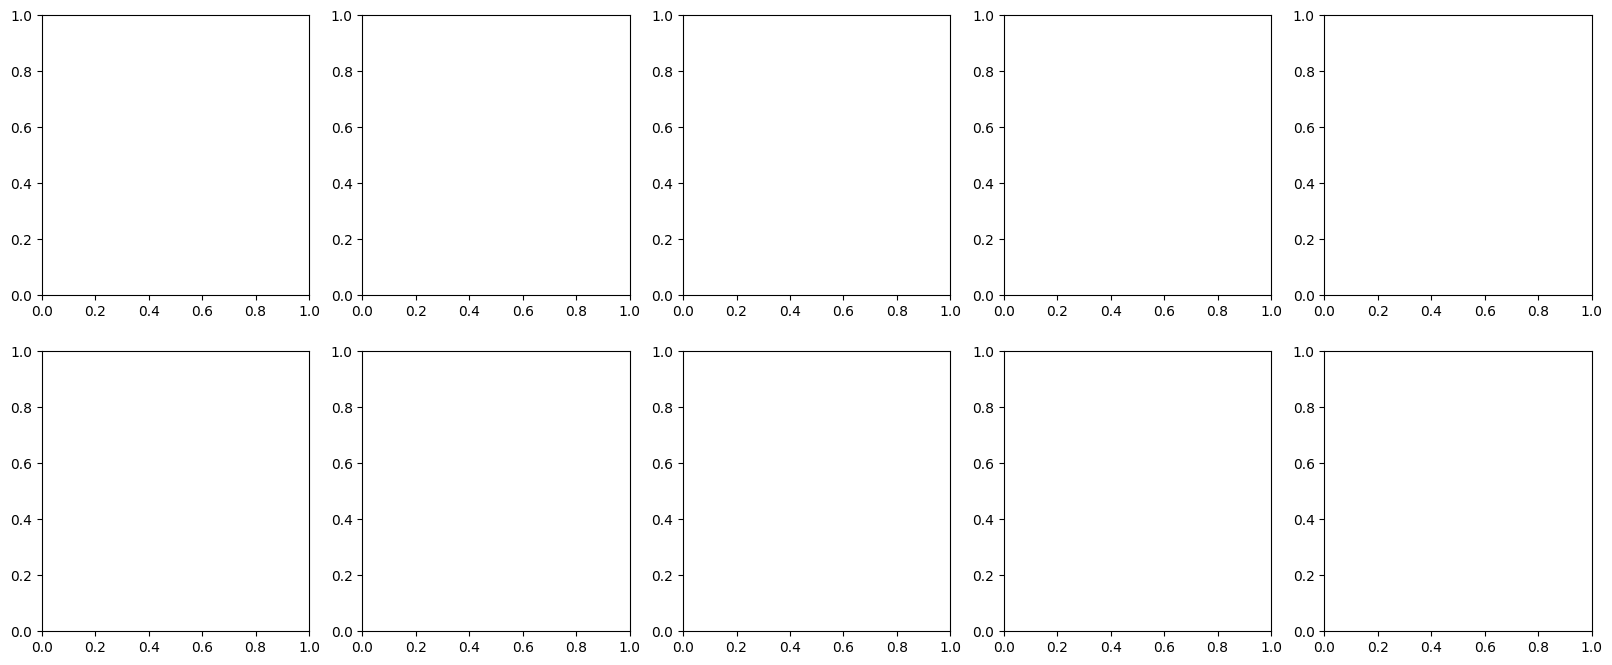

In [46]:
df=df_cards

df = df[df['edhrec_rank'].notnull()]  # Filtrar cartas sem rank EDHREC
df = df.sort_values('edhrec_rank').head(10)  # Top 10 cartas

# Mostrar imagens das cartas
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, (index, row) in enumerate(df.iterrows()):
    image_uris = row['image_uris']
    if isinstance(image_uris, dict):
        img_url = image_uris.get('normal')
        if img_url:
            response = requests.get(img_url)
            img = Image.open(BytesIO(response.content))
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"{row['name']} (Rank: {row['edhrec_rank']})", fontsize=12)
        else:
            axes[i].axis('off')
            axes[i].set_title(f"{row['name']} (Rank: {row['edhrec_rank']})\nImagem não disponível", fontsize=12)
    else:
        axes[i].axis('off')
        axes[i].set_title(f"{row['name']} (Rank: {row['edhrec_rank']})\nImagem não disponível", fontsize=12)

plt.tight_layout()
plt.show()



In [49]:
df

,object,id,oracle_id,multiverse_ids,mtgo_id,tcgplayer_id,cardmarket_id,name,lang,released_at,...,preview.source,preview.source_uri,preview.previewed_at,arena_id,produced_mana,mtgo_foil_id,all_parts,watermark,loyalty,card_faces
120,card,bd3d4b4b-cf31-4f89-8140-9650edb03c7b,23467047-6dba-4498-b783-1ebc4f74b8c2,[456832],70055.0,179473,366213.0,Ancient Tomb,en,2018-12-07,...,NaN,NaN,NaN,NaN,[C],70056.0,NaN,NaN,NaN,NaN
144,card,16de91dc-5d82-43ec-84ad-67bae644795a,ad09b3c3-c8e7-481c-8c45-e7f234935117,[571503],101824.0,276502,664972.0,Anguished Unmaking,en,2022-07-08,...,MagicBlogs,https://magicblogs.de/blog/8520-zwei-exklusive...,2022-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,card,47f39b5e-2e85-4f31-bbab-0b0bf58f701d,f9db72dc-9a5b-48a4-a86e-7464d9a2166a,[636839],118074.0,526138,743390.0,Abrade,en,2023-11-17,...,Wizards of the Coast,https://vxtwitter.com/wizards_magic/status/171...,2023-11-01,87279.0,NaN,NaN,NaN,NaN,NaN,NaN
148,card,1489943b-c010-488e-9c9d-87f4af67a4e4,c0d8fef4-65f4-4769-982d-b397d2b7e977,[650219],122390.0,535784,753362.0,Animate Dead,en,2024-02-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,card,608cdbdb-6f7e-438a-bab0-0e7782435f0f,fd949f82-fc10-4e37-8aa9-6c7569fe3c55,[640421],118646.0,526216,743478.0,Akroma's Will,en,2023-11-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,card,76480f4d-ad6d-4ed6-82c6-fa12abc22557,f36d1d8b-8303-44a9-ab56-531931641ea2,[658695],124965.0,545341,764937.0,Academy Manufactor,en,2024-04-19,...,NaN,NaN,NaN,NaN,NaN,NaN,"[{'object': 'related_card', 'id': '7ec6f053-96...",NaN,NaN,NaN
174,card,4b81165e-f091-4211-8b47-5ea6868b0d4c,4567a528-75f0-4ea6-b927-3a500caf76ac,[442149],67234.0,161851,319538.0,Arbor Elf,en,2018-03-16,...,NaN,NaN,NaN,NaN,NaN,67235.0,NaN,set,NaN,NaN
29,card,08ae1037-6f70-41a9-b75e-98fa9a2152c8,d5ad26cc-2bdb-46b7-b8bf-dd099d5fa09b,[574723],102962.0,282752,671393.0,Adarkar Wastes,en,2022-09-09,...,NaN,NaN,NaN,82295.0,"[C, U, W]",NaN,NaN,NaN,NaN,NaN
141,card,0c7ce363-3f57-49ed-b89a-f12bb5227ab4,eaabd151-2160-4bff-82c0-3fa88659be98,[532500],NaN,243844,572286.0,Anger,en,2021-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,card,0a508907-a127-45cd-898a-e936bc08391f,02f16726-f2f6-4943-b71a-93f8e26251d3,[519311],89657.0,236149,558547.0,Ancient Den,en,2021-04-23,...,NaN,NaN,NaN,NaN,[W],NaN,NaN,NaN,NaN,NaN


In [56]:
df_sorted = df_commander.sort_values(by='edhrec_rank')

In [57]:
df_sorted=df_sorted[['name','scryfall_uri','edhrec_rank']]
df_sorted

,name,scryfall_uri,edhrec_rank
33,Abrade,https://scryfall.com/card/lci/131/abrade?utm_s...,171
80,Academy Manufactor,https://scryfall.com/card/otc/251/academy-manu...,309
147,Adarkar Wastes,https://scryfall.com/card/dmu/243/adarkar-wast...,402
151,"Adeline, Resplendent Cathar",https://scryfall.com/card/moc/167/adeline-resp...,528
84,Academy Ruins,https://scryfall.com/card/2xm/309/academy-ruin...,553
...,...,...,...
145,Adarkar Unicorn,https://scryfall.com/card/ice/1/adarkar-unicor...,26184
105,Acidic Dagger,https://scryfall.com/card/mir/291/acidic-dagge...,26190
144,Adarkar Sentinel,https://scryfall.com/card/me2/201/adarkar-sent...,26217
11,Abbey Matron,https://scryfall.com/card/hml/2a/abbey-matron?...,26515
